In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Networks

In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from src.data_loader import *
from src.helpers import filter_most_specific_category
from src.network_helpers import *

In [24]:
df_finished = read_finished_paths()
df_unfinished = read_unfinished_paths()
df_categories = read_categories()   
df_categories_filtered = filter_most_specific_category(df_categories)

df_finished['path'] = df_finished['path'].apply(replace_back_clicks)
df_unfinished['path'] = df_unfinished['path'].apply(replace_back_clicks)

Finished Paths 
Number of rows before filtering: 51318
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of rows after filtering: 51210 

Unfinished Paths 
Number of rows before filtering: 24875
Invalid target articles found: {'Macedonia', 'Podcast', 'English', 'Kashmir', 'Netbook', 'The', 'Bogota', 'Sportacus', 'Long peper', 'Western Australia', 'Rat', 'Christmas', 'The Rock', 'Adolph Hitler', 'Black ops 2', 'Great', 'Mustard', 'Georgia', 'Rss', ' Zebra', 'Pikachu', 'Usa', 'Charlottes web', 'Fats', 'Test'}
Invalid articles found in path: {'Pikachu', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows dropped of type 'timeout' with a duration less than 30 minutes: 7 Type 'timeout' occurs only after 30 minutes of inactivity, thus this path are technically impossible.
Number of rows after filtering: 24714 



In [45]:
category_abbreviations = {
    'Art': 'Art',
    'Mathematics': 'Math',
    'IT': 'IT',
    'Business Studies': 'BS',
    'Music': 'Music',
    'Religion': 'R',
    'Language and literature': 'L&L',
    'Citizenship': 'CIT',
    'Countries': 'C',
    'Design and Technology': 'D&T',
    'Everyday life': 'Life',
    'History': 'Hist',
    'People': 'P',
    'Geography': 'Geo',
    'Science': 'Sci'
}

In [46]:
G = build_network(df_finished, df_categories_filtered, include_self_loops=False)
G = normalize_edge_weights(G, df_categories_filtered)

# Filter the network based on a chosen weight threshold and show onlt the top_n edges
H = filter_network(G, weight_threshold=0, top_n=None)

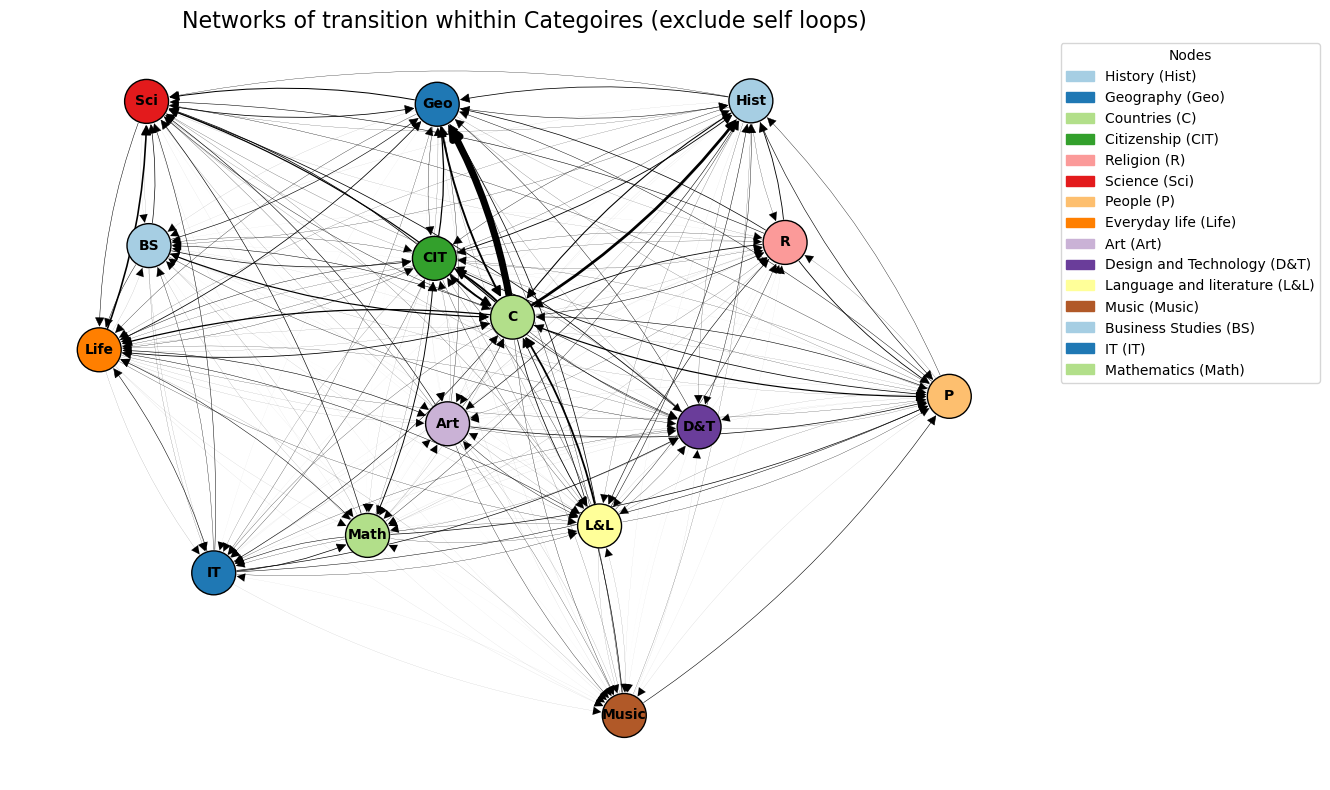

In [47]:
plot_network(G, title="Networks of transition whithin Categoires (exclude self loops)", show_edge_labels=False, node_size=1000, node_abbreviations=category_abbreviations)

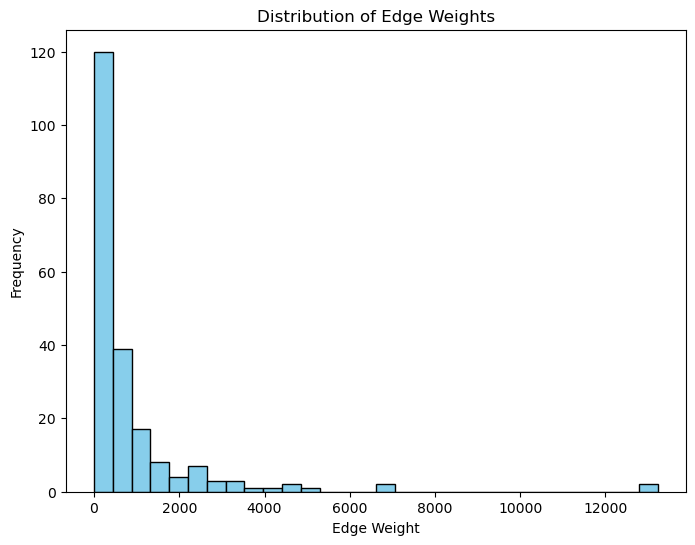

Mean Weight: 846.3428571428572
Median Weight: 297.0
75th Percentile: 876.25
90th Percentile: 2245.7


In [49]:
mean_weight, median_weight, percentile_75, percentile_90 = analyze_edge_weights(H)

In [50]:
def get_top_edges(G, top_n=10):
    """
    Get the top N edges with the highest weights.
    """
    edges = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]
    top_edges = sorted(edges, key=lambda x: x[2], reverse=True)[:top_n]
    df_top_edges = pd.DataFrame(top_edges, columns=['Source', 'Target', 'Weight'])
    return df_top_edges

# Example usage:
top_edges = get_top_edges(G, top_n=40)
print("Top 20 Transitions Between Categories:")
print(top_edges)

Top 20 Transitions Between Categories:
                     Source                   Target  Weight
0                 Countries                Geography   13227
1                 Geography                Countries   12833
2                 Geography                  Science    6699
3                   Science                Geography    6661
4                 Countries                  History    5221
5             Everyday life                  Science    4814
6                   History                Countries    4411
7                   Science            Everyday life    4280
8                 Countries              Citizenship    3792
9                 Geography                  History    3341
10                  Science                Countries    3338
11              Citizenship                Countries    3246
12                  History                Geography    3076
13  Language and literature                Countries    2938
14                   People                Cou

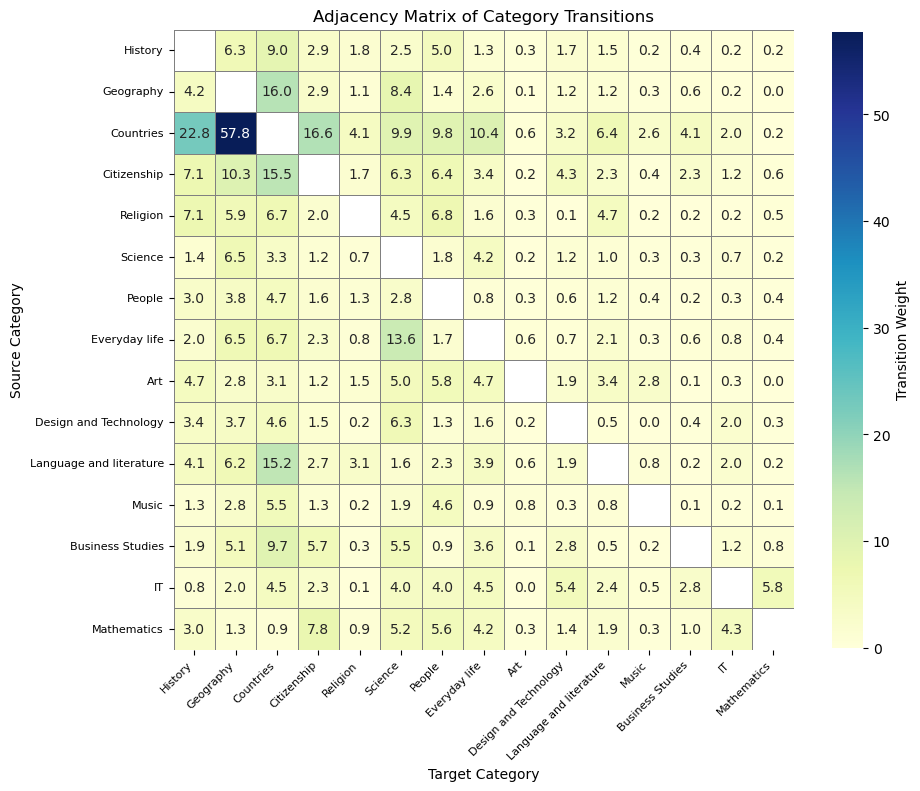

In [ ]:
adj_matrix = nx.to_pandas_adjacency(G, weight='weight')

# Plot the adjacency matrix
plt.figure(figsize=(10, 10))
# Create a mask for zero values
mask = adj_matrix == 0
# Plot with a diverging color map and mask for zero values
sns.heatmap(adj_matrix, cmap='YlGnBu', mask=mask, annot=True, fmt='0.1f', cbar_kws={'label': 'Transition Weight', 'shrink': 0.8},
            linewidths=0.5, linecolor='grey', vmin=adj_matrix.values.min(), vmax=adj_matrix.values.max(), square=True)
plt.title("Adjacency Matrix of Category Transitions")
plt.xlabel("Target Category")
plt.ylabel("Source Category")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# Articles with multi-Categories

In [ ]:
from src.data_loader import read_categories

In [ ]:
df_categories = read_categories()
# Count artices with multiple categories
df_categories['article'].value_counts().value_counts()

count
1    3999
2     590
3       8
Name: count, dtype: int64

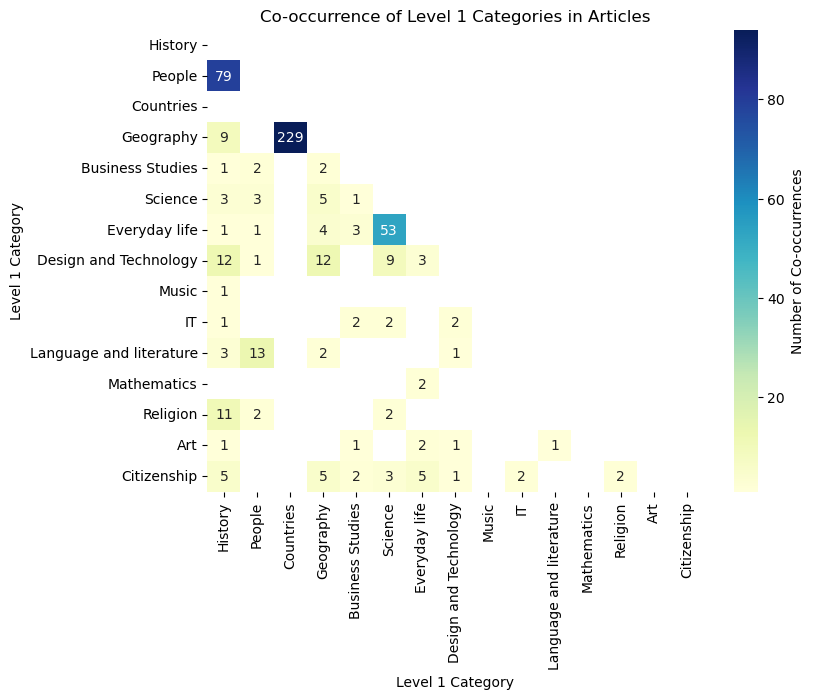

,Category Pair,Articles,Article Count
0,"(Geography, Countries)","[Åland, Éire, Abkhazia, Abu Dhabi, Afghanistan...",229
1,"(History, People)","[Áedán mac Gabráin, Óengus I of the Picts, Akh...",79
2,"(Everyday life, Science)","[Almond, Aquarium, Avocado, Barley, Basil, Bea...",53
3,"(People, Language and literature)","[Augusta, Lady Gregory, Benjamin Britten, Coll...",13
4,"(History, Design and Technology)","[Avro Lancaster, Castra, Colossus of Rhodes, F...",12


In [ ]:
# Step 1: Filter articles with multiple categories
multi_category_articles = df_categories.groupby('article').filter(lambda x: len(x) > 1)

# Step 2: Create pairs of category co-occurrences for each article with multiple categories
category_pairs = []
article_pairs = defaultdict(list)  # Dictionary to store articles for each unique category pair

for article in multi_category_articles['article'].unique():
    categories = multi_category_articles[multi_category_articles['article'] == article]['level_1'].unique()
    for pair in combinations(categories, 2):
        pair_set = frozenset(pair)  # Use a frozenset to ignore order
        category_pairs.append(pair_set)
        article_pairs[pair_set].append(article)  # Add the article to the respective pair list

# Step 3: Count the occurrences of each pair
pair_counts = Counter(category_pairs)

# Step 4: Convert pair_counts to a DataFrame for heatmap plotting
categories = df_categories['level_1'].unique()
heatmap_data = pd.DataFrame(0, index=categories, columns=categories)

# Step 5: Fill in the DataFrame with pair counts
for pair, count in pair_counts.items():
    cat1, cat2 = list(pair)
    heatmap_data.loc[cat1, cat2] = count
    heatmap_data.loc[cat2, cat1] = count  # Ensure symmetry

# Now, article_pairs contains each unique pair (unordered) with the list of associated articles

# Step 6: Plot the heatmap with a mask for the upper triangle, excluding zeros
mask = np.triu(np.ones_like(heatmap_data, dtype=bool)) | (heatmap_data == 0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", mask=mask,                      
            cbar_kws={'label': 'Number of Co-occurrences'}, fmt="g", robust=True)
plt.title("Co-occurrence of Level 1 Categories in Articles")
plt.xlabel("Level 1 Category")
plt.ylabel("Level 1 Category")
plt.show()

# Step 7: Convert article_pairs dictionary to a DataFrame with category pairs as sets and associated articles
article_pairs_df = pd.DataFrame([(pair, articles) for pair, articles in article_pairs.items()],
                                columns=['Category Pair', 'Articles'])

article_pairs_df['Article Count'] = article_pairs_df['Articles'].apply(len)  # Add count of articles
article_pairs_df = article_pairs_df.sort_values(by='Article Count', ascending=False).reset_index(drop=True)

# Display the DataFrame containing unique category pairs as sets and associated articles
article_pairs_df.head()

# Matrix of transitions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations

from src.data_loader import read_categories

In [ ]:
data_f_loops = pd.read_csv('common_paths_f.csv')
data_f_no_loops = pd.read_csv('common_paths_f_nl.csv')

In [ ]:
def matrix_common_paths(data):  
    # Extract transitions and create transition counts
    transitions = {}
    for _, row in data.iterrows():
        path = row['Category Path'].split(" -> ")
        count = row['Count']
        for i in range(len(path) - 1):
            from_cat = path[i]
            to_cat = path[i + 1]
            if from_cat not in transitions:
                transitions[from_cat] = {}
            if to_cat not in transitions[from_cat]:
                transitions[from_cat][to_cat] = 0
            transitions[from_cat][to_cat] += count

    # Create transition matrix DataFrame
    categories = sorted(set([key for key in transitions] + [k for subdict in transitions.values() for k in subdict]))
    transition_matrix = pd.DataFrame(0, index=categories, columns=categories)

    # Populate the transition matrix with counts
    for from_cat, to_cats in transitions.items():
        for to_cat, count in to_cats.items():
            transition_matrix.at[from_cat, to_cat] = count
    
    return transition_matrix

In [ ]:
matrix_loops = matrix_common_paths(data_f_loops)

Text(0.5, 1.0, 'Total transitions to each category')

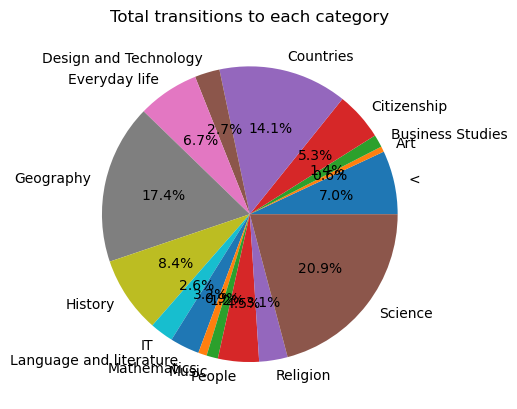

In [ ]:
total_transitions_to = matrix_loops.sum()

# plot a pie chart of the matrix_with_sums
fig, ax = plt.subplots()
ax.pie(total_transitions_to, labels=total_transitions_to.index, autopct='%1.1f%%')
ax.set_title('Total transitions to each category')

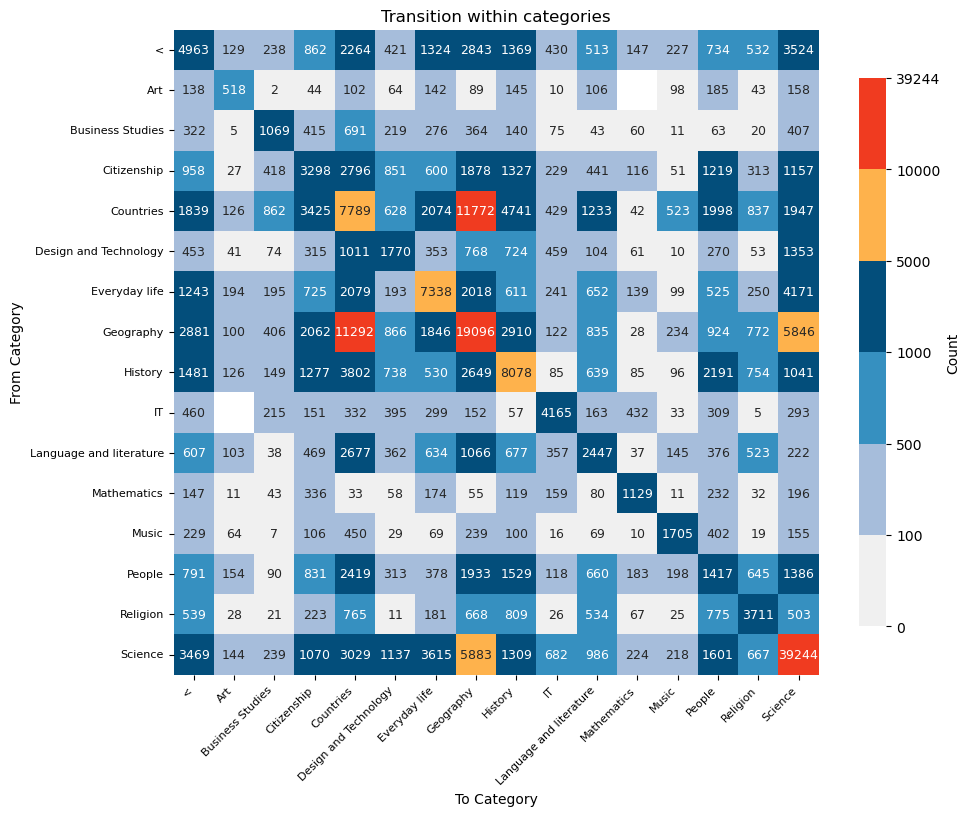

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Get max value for setting the color scale
max_value = matrix_loops.values.max()

# Define thresholds and corresponding colors
thresholds = [0, 100, 500, 1000, 5000, 10000, max_value]  # Adjust based on data range
colors = ["#f0f0f0", "#a6bddb", "#3690c0", "#034e7b", "#feb24c", "#f03b20"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(thresholds, len(colors))


plt.figure(figsize=(10, 10))

# Mask zeros for better visibility in log scale
mask = matrix_loops == 0
sns.heatmap(matrix_loops, annot=True, annot_kws={"size": 9}, fmt="d", 
            mask=mask, cmap=cmap, norm=norm, cbar_kws={'label': 'Count', 'shrink': 0.6} , square=True)
plt.title('Transition within categories')
plt.xlabel('To Category')
plt.ylabel('From Category')
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8) 

plt.tight_layout()
plt.show()